In [1]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""A deep MNIST classifier using convolutional layers.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/pros
"""
# Disable linter warnings to maintain consistency with tutorial.
# pylint: disable=invalid-name
# pylint: disable=g-bad-import-order

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import os
import shutil
import tempfile

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data



def add(x, y):
    return tf.nn.bias_add(x, y, data_format="NHWC")


def deepnn(x):
    """deepnn builds the graph for a deep net for classifying digits.
    Args:
      x: an input tensor with the dimensions (N_examples, 784), where 784 is the
      number of pixels in a standard MNIST image.
    Returns:
      A tuple (y, keep_prob). y is a tensor of shape (N_examples, 10), with values
      equal to the logits of classifying the digit into one of 10 classes (the
      digits 0-9). keep_prob is a scalar placeholder for the probability of dropout.
    """
    # Reshape to use within a convolutional neural net.
    # Last dimension is for "features" - there is only one here, since images are
    # grayscale -- it would be 3 for an RGB image, 4 for RGBA, etc.
    with tf.name_scope('reshape'):
        x_image = tf.reshape(x, [-1, 1, 28, 28])
    x_image = tf.transpose(x_image, [0, 2, 3, 1])

    # First convolutional layer - maps one grayscale image to 32 feature maps.
    with tf.name_scope('conv1'):
        w_conv1 = weight_variable([5, 5, 1, 32])
        b_conv1 = bias_variable([32])
        h_conv1 = tf.nn.relu(add(conv2d(x_image, w_conv1), b_conv1))

    # Pooling layer - downsamples by 2X.
    with tf.name_scope('pool1'):
        h_pool1 = max_pool_2x2(h_conv1)

    # Second convolutional layer -- maps 32 feature maps to 64.
    with tf.name_scope('conv2'):
        w_conv2 = weight_variable([5, 5, 32, 64])
        b_conv2 = bias_variable([64])
        h_conv2 = tf.nn.relu(add(conv2d(h_pool1, w_conv2), b_conv2))

    # Second pooling layer.
    with tf.name_scope('pool2'):
        h_pool2 = max_pool_2x2(h_conv2)

    # Fully connected layer 1 -- after 2 round of downsampling, our 28x28 image
    # is down to 7x7x64 feature maps -- maps this to 1024 features.
    with tf.name_scope('fc1'):
        w_fc1 = weight_variable([7 * 7 * 64, 1024])
        b_fc1 = bias_variable([1024])

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, w_fc1) + b_fc1)

    # Map the 1024 features to 10 classes, one for each digit
    with tf.name_scope('fc2'):
        w_fc2 = weight_variable([1024, 10])
        b_fc2 = bias_variable([10])

        y_conv = tf.matmul(h_fc1, w_fc2) + b_fc2

    return y_conv


def conv2d(x, w):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, w, strides=[1, 1, 1, 1], padding='SAME', data_format="NHWC")


def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME', data_format="NHWC")


def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)


def create_and_train_mnist():
    tf.logging.set_verbosity(tf.logging.ERROR)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    # Import data
    data_dir = r"/tmp/tensorflow/mnist/input_data"
    mnist = input_data.read_data_sets(data_dir)
    # Create the model
    tf.reset_default_graph()
    input_tensor = tf.placeholder(tf.float32, [None, 784], name="input")
    # Build the graph for the deep net
    y_conv = deepnn(input_tensor)
    output_tensor = tf.identity(y_conv, "result")
    with open("./output/graph.proto", "wb") as file:
        graph = tf.get_default_graph().as_graph_def(add_shapes=True)
        file.write(graph.SerializeToString())
    # Define loss and optimizer
    y_ = tf.placeholder(tf.int64, [None])
    with tf.name_scope('loss'):
        cross_entropy = tf.losses.sparse_softmax_cross_entropy(
            labels=y_, logits=y_conv)
    cross_entropy = tf.reduce_mean(cross_entropy)
    with tf.name_scope('adam_optimizer'):
        train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    with tf.name_scope('accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
        correct_prediction = tf.cast(correct_prediction, tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    saver = tf.train.Saver()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    sess.run(tf.global_variables_initializer())
    for i in range(5000):
        batch = mnist.train.next_batch(50)
        if i % 1000 == 0:
            train_accuracy = accuracy.eval(session=sess, feed_dict={input_tensor: batch[0], y_: batch[1]})
            print('step %d, training accuracy %g' % (i, train_accuracy))
        train_step.run(session=sess, feed_dict={input_tensor: batch[0], y_: batch[1]})

    print('test accuracy %g' % accuracy.eval(session=sess, feed_dict={input_tensor: mnist.test.images[:1000], y_: mnist.test.labels[:1000]}))
    return sess, saver, input_tensor, output_tensor

def save_model_to_checkpoint(saver, sess):
    print("save model to checkpoint")
    save_path = saver.save(sess, "./output/ckpt/model.ckpt")

def save_model_to_frozen_proto(sess):
    print('save model to frozen graph')
    frozen_graph = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["result"])
    with open("./output/mnist_frozen.pb", "wb") as file:
         file.write(frozen_graph.SerializeToString())

def save_model_to_saved_model(sess, input_tensor, output_tensor):
    print('save model to saved_model')
    from tensorflow.saved_model import simple_save
    save_path = r"./output/saved_model"
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    simple_save(sess, save_path, {input_tensor.name: input_tensor}, {output_tensor.name: output_tensor})

In [10]:
# generating mnist.onnx using saved_model
!python -m tf2onnx.convert --saved-model ./saved_model --output ./output/segmentation.onnx --opset 7


2020-12-05 17:25:39,808 - WARNING - From /home/raphael/anaconda3/envs/tf1/lib/python3.6/site-packages/tf2onnx/verbose_logging.py:76: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

2020-12-05 17:25:39,893 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2020-12-05 17:25:40,715 - INFO - Using tensorflow=1.15.0, onnx=1.8.0, tf2onnx=1.7.2/995bd6
2020-12-05 17:25:40,715 - INFO - Using opset <onnx, 7>
2020-12-05 17:25:40,792 - INFO - Computed 8 values for constant folding
2020-12-05 17:25:41,013 - INFO - folding node using tf type=Identity, name=conv1/Variable/read
2020-12-05 17:25:41,013 - INFO - folding node using tf type=Identity, name=conv1/Variable_1/read
2020-12-05 17:25:41,013 - INFO - folding node using tf type=Identity, name=conv2/Variable/read
2020-12-05 17:25:41,014 - INFO - folding node using tf type=Identity, name=conv2/Variable_1/read
2020-12-05 17:25:41,014 - INFO - folding node using tf type=Identi

In [5]:
import os
import shutil
import tensorflow as tf
#from assets.tensorflow_to_onnx_example import create_and_train_mnist
def save_model_to_saved_model(sess, input_tensor, output_tensor):
    from tensorflow.saved_model import simple_save
    save_path = r"./output/saved_model"
    if os.path.exists(save_path):
        shutil.rmtree(save_path)
    simple_save(sess, save_path, {input_tensor.name: input_tensor}, {output_tensor.name: output_tensor})

print("please wait for a while, because the script will train MNIST from scratch")
tf.reset_default_graph()
sess_tf, saver, input_tensor, output_tensor = create_and_train_mnist()
print("save tensorflow in format \"saved_model\"")
save_model_to_saved_model(sess_tf, input_tensor, output_tensor)

please wait for a while, because the script will train MNIST from scratch
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
step 0, training accuracy 0.22
step 1000, training accuracy 0.92
step 2000, training accuracy 0.98
step 3000, training accuracy 1
step 4000, training accuracy 1
test accuracy 0.975
save tensorflow in format "saved_model"


In [13]:
import numpy as np
import onnxruntime as ort

img = np.load("image.npz").reshape([1, 784])  
sess_ort = ort.InferenceSession("./output/mnist1.onnx")
res = sess_ort.run(output_names=[output_tensor.name], input_feed={input_tensor.name: img})
print("the expected result is \"7\"")
print("the digit is classified as \"%s\" in ONNXRruntime"%np.argmax(res))


the expected result is "7"
the digit is classified as "7" in ONNXRruntime


In [56]:
sess_ort = ort.InferenceSession("./output/segmentation.onnx")
import time
start = time.time()
qty = 10
for i in range(0,10):
    res = sess_ort.run(output_names=["output:0"], input_feed={"input_rgb:0": img.reshape((1,120,160,3))})
end = time.time()
delta=end-start
seg = res[0]
1/(delta/qty)

32.45295281896217

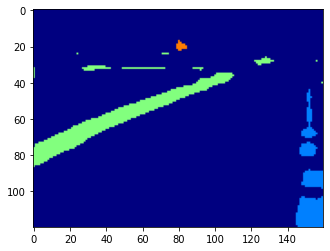

In [42]:
from cv2_plt_imshow import cv2_plt_imshow
seg = cv2.imread(f"logs/segmentation_results/{image_num}_raw_prediction.png",cv2.IMREAD_GRAYSCALE)
yellow = (seg==1).astype(np.uint8)
white = (seg==2).astype(np.uint8)
cv2_plt_imshow(cv2.applyColorMap(seg*64, cv2.COLORMAP_JET))

In [29]:
input_name = sess_ort.get_inputs()[0].name
output_name = sess_ort.get_outputs()[0].name
input_name, output_name

('input_rgb:0', 'output:0')

In [32]:
sess_ort.get_inputs()[0].shape

[1, 120, 160, 3]